In [148]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('../../')

In [149]:
import yaml
from pathlib import Path
from typing import Union
from functools import reduce

def save_yaml_from_csvs(directory_path: Union[str, Path], replace_in_filename: dict[str, str] = None) -> Path:
    directory = Path(directory_path)
    yaml_data = []
    
    for file in directory.glob('*.xlsx'):
        df = pd.read_excel(file)
        entry = {
            'file': reduce(lambda fn, kv: fn.replace(*kv), replace_in_filename.items(), file.name),
            'timestamp_missed_fish': [],
            'fish_track_IDs': df[df['classification'] == 'fish']['id'].tolist(),
        }
        yaml_data.append(entry)
    
    yaml_file_path = directory / "fish_labels.yaml"
    
    with open(yaml_file_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)
    
    return yaml_file_path

directory_path = "../../data/labels/Tourelle/"
output_yaml_path = save_yaml_from_csvs(directory_path, replace_in_filename={"_YP_completed": "", ".xlsx": ".csv"})
print(f"YAML file saved at: {output_yaml_path}")


YAML file saved at: ../../data/labels/Tourelle/fish_labels.yaml


In [159]:
%load_ext autoreload
%autoreload 2
from analysis.classification_utils.features import FeatureGenerator, TrackClassifier, TrackPlotter


gt_fish_id_yaml = "../../data/labels/Tourelle/fish_labels.yaml"

gen = FeatureGenerator(
    gt_fish_id_yaml=gt_fish_id_yaml,
    measurements_csv_dir="../../data/model_output/",
    min_track_length=20, 
    force_feature_recalc=True,
    force_test_feature_recalc=True,
    min_overlapping_ratio=0.5,
    load_old_measurements=False,
    load_old_test_files=False,
    rake_mask_path="../demo/masks/stroppel_rake_front_mask.png",
    flow_area_mask_path="../demo/masks/sonar_controls.png",
    trajectory_min_overlap_ratio=0.15,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculating/reading features


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Calculating/reading features


0it [00:00, ?it/s]


In [160]:
gen.calc_feature_dfs()
mmts_dfs = gen.measurements_dfs.copy()

Calculating features for train data


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWar

# Get an Idea of Trajectory and Ground Truth

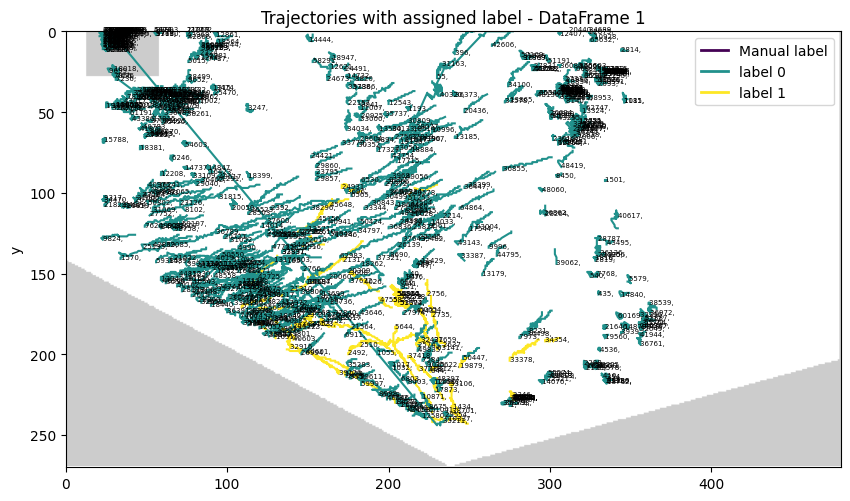

In [161]:
from analysis.classification_utils.features import TrackPlotter

plotter = TrackPlotter(mmts_dfs, gen.masks)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

# Identify River Velocity from Floating Debris Cluster

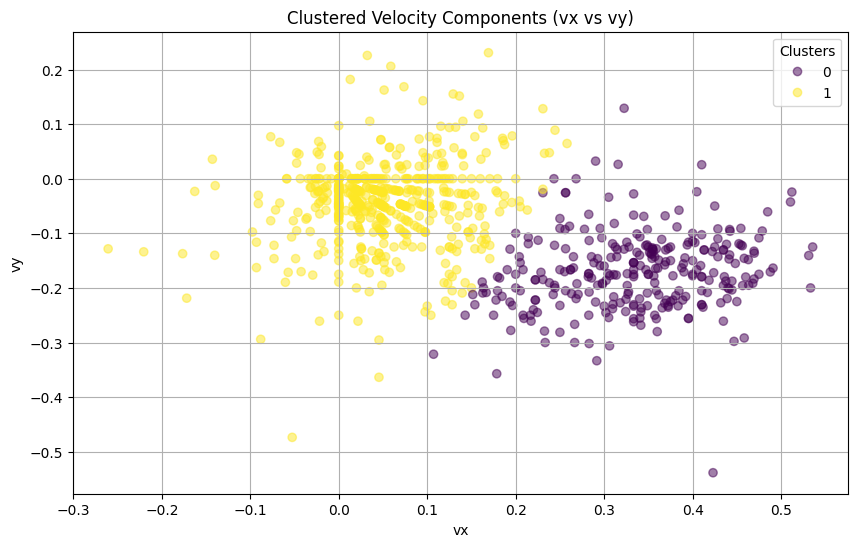

Cluster Centers:
 [[ 0.33409843 -0.17047265]
 [ 0.05060615 -0.04405702]]


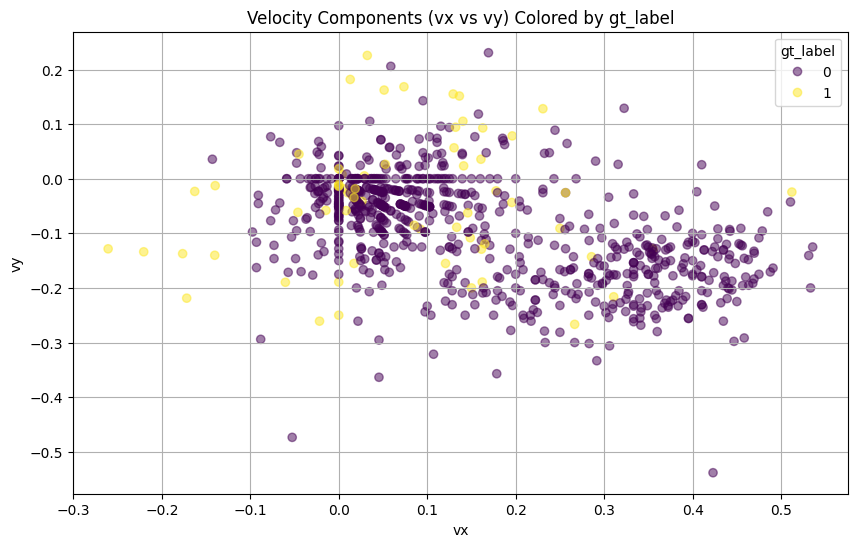

In [162]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

def calculate_velocities(mmts_dfs):
    velocities = []

    for df in mmts_dfs:
        unique_ids = df['id'].unique()
        for uid in unique_ids:
            sample = df[df.id == uid]
            if len(sample) > 1:  # Ensure there are at least two points to calculate velocity
                dx = sample.x.iloc[-1] - sample.x.iloc[0]
                dy = sample.y.iloc[-1] - sample.y.iloc[0]
                dt = sample.frame.iloc[-1] - sample.frame.iloc[0]
                vx = dx / dt
                vy = dy / dt
                gt_label = sample.gt_label.iloc[0]  # Assuming gt_label is the same for all points of the same id
                velocities.append((uid, vx, vy, gt_label))
    
    return pd.DataFrame(velocities, columns=['id', 'vx', 'vy', 'gt_label'])

# Assuming mmts_dfs is already defined
velocities_df = calculate_velocities(mmts_dfs)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)  # You can change the number of clusters
velocities_df['cluster'] = kmeans.fit_predict(velocities_df[['vx', 'vy']])

# Plotting clustered velocities
plt.figure(figsize=(10, 6))
scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Velocity Components (vx vs vy)')
plt.xlabel('vx')
plt.ylabel('vy')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# Get cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

# Plotting velocities colored by gt_label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(velocities_df['vx'], velocities_df['vy'], c=velocities_df['gt_label'], cmap='viridis', alpha=0.5)
plt.title('Velocity Components (vx vs vy) Colored by gt_label')
plt.xlabel('vx')
plt.ylabel('vy')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="gt_label")
plt.show()

# Clean Trajectory Data

In [157]:
import pandas as pd
import numpy as np

def remove_jumps(df, threshold=10):
    # Calculate the Euclidean distance between consecutive points
    df['dist'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
    
    # Find the indices where the distance is greater than the threshold
    jump_indices = df.index[df['dist'] > threshold].tolist()
    
    # Add the start and end indices of the DataFrame
    jump_indices = [df.index[0]] + jump_indices + [df.index[-1]]
    
    # Split the DataFrame into segments at the jump indices
    segments = [df.loc[jump_indices[i]:jump_indices[i+1]] for i in range(len(jump_indices)-1)]
    
    # Remove the shorter part of the track before or after each jump
    for i in range(1, len(segments)-1):
        if len(segments[i-1]) < len(segments[i+1]):
            segments[i-1] = pd.DataFrame()
        else:
            segments[i+1] = pd.DataFrame()
    
    # Concatenate the segments back into a single DataFrame
    df = pd.concat(segments).drop(columns='dist')
    
    return df

# Apply the function to each DataFrame in mmts_dfs
mmts_dfs = [remove_jumps(df) for df in mmts_dfs]

plotter = TrackPlotter(mmts_dfs, gen.masks)

In [163]:
feature_df = pd.concat(mmts_dfs).groupby('id').first().select_dtypes(include=[np.number])
feature_df.drop(
    columns=[
        'x_avg',
        'y_avg',
        'video_id',
    ], 
    inplace=True
)

# Check for NaN values in the DataFrame
nan_values = feature_df.isna()
nan_counts = feature_df.isna().sum()

# Print the columns that have NaN values
print(nan_counts)

# drop rows with NaN values
feature_df = feature_df.dropna()

frame                                              0
x                                                  0
y                                                  0
w                                                  0
h                                                  0
v_x                                                0
v_y                                                0
contour_area                                       0
stddev_of_intensity                                0
v_xr                                               0
v_yr                                               0
tile_blob_counts                                   0
x_displacement                                     0
y_displacement                                     0
v_x_smoothed_avg                                   2
v_y_smoothed_avg                                   2
v_smoothed_avg                                     2
v_smoothed_std                                     2
v_10th_percentile                             

In [165]:
feature_df[['v_x_smoothed_avg']].isna()

,v_x_smoothed_avg
id,
1,False
5,False
34,False
40,False
55,False
...,...
65824,False
66115,False
66121,False


In [166]:
from sklearn.ensemble import RandomForestClassifier

# Assuming feature_dfs is your DataFrame and 'gt_label' is your target variable
X = feature_df.drop('gt_label', axis=1)
y = feature_df['gt_label']

# Initialize the model
model = RandomForestClassifier(random_state=1)

# Fit the model
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

                                           feature  importance
2                                                y    0.076087
36                                      frame_diff    0.061154
12                                  x_displacement    0.038171
14                                v_x_smoothed_avg    0.036989
13                                  y_displacement    0.036870
0                                            frame    0.035931
29                          v_x_relative_river_avg    0.035744
43                           average_overlap_ratio    0.034381
35                              traversed_distance    0.034087
25                            v_parallel_river_avg    0.032896
15                                v_y_smoothed_avg    0.031746
1                                                x    0.029852
30                          v_y_relative_river_avg    0.028773
26                          v_orthogonal_river_avg    0.027578
48                     average_distance_from_start    0

In [169]:
feature_df.columns

Index(['frame', 'x', 'y', 'w', 'h', 'v_x', 'v_y', 'contour_area',
       'stddev_of_intensity', 'v_xr', 'v_yr', 'tile_blob_counts',
       'x_displacement', 'y_displacement', 'v_x_smoothed_avg',
       'v_y_smoothed_avg', 'v_smoothed_avg', 'v_smoothed_std',
       'v_10th_percentile', 'v_30th_percentile', 'v_50th_percentile',
       'v_70th_percentile', 'v_90th_percentile', 'v_95th_percentile',
       'v_99th_percentile', 'v_parallel_river_avg', 'v_orthogonal_river_avg',
       'v_parallel_river_median', 'v_orthogonal_river_median',
       'v_x_relative_river_avg', 'v_y_relative_river_avg',
       'v_x_relative_river_median', 'v_y_relative_river_median',
       'v_relative_river_avg', 'v_relative_river_median', 'traversed_distance',
       'frame_diff', 'average_curvature', 'average_smoothed_curvature_15',
       'average_smoothed_curvature_25', 'median_curvature',
       'median_smoothed_curvature_15', 'median_smoothed_curvature_25',
       'average_overlap_ratio', 'average_bbox_size'

In [178]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def f_beta(beta: float, precision: float, recall: float) -> float:
    return (1 + beta**2) * precision * recall / (beta**2 * precision + recall) 

class RandomClassifier():
    
    def __init__(self, class_counts: dict[int, int]):
        self.class_counts = class_counts
        total_count = sum(class_counts.values())
        self.class_probabilities = {k: v / total_count for k, v in class_counts.items()}
                
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        pass
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # draw random samples from distribuiton of classes
        classes = list(self.class_probabilities.keys())
        probabilities = list(self.class_probabilities.values())
        return np.random.choice(classes, size=X.shape[0], p=probabilities)   
    

random_state = 3
imbalance = feature_df['gt_label'].value_counts()[0] / sum(feature_df['gt_label'].value_counts())
classifiers = {
    'gradient_boosting': GradientBoostingClassifier(random_state=random_state),
    'random_forest': RandomForestClassifier(random_state=random_state, class_weight='balanced'),
    'xgboost': XGBClassifier(random_state=random_state, scale_pos_weight=imbalance),  # Adjust scale_pos_weight based on imbalance ratio
    'logistic_regression': LogisticRegression(random_state=random_state, class_weight='balanced'),
    'svm': SVC(random_state=random_state, class_weight='balanced'),
    'adaboost': AdaBoostClassifier(random_state=random_state),
    'knn': KNeighborsClassifier(),
    'random_benchmark': RandomClassifier(feature_df['gt_label'].value_counts().to_dict()),
}
classifiers['vote_best_3'] = VotingClassifier(
    estimators=[
        ('gradient_boosting', classifiers['gradient_boosting']),
        ('xgboost', classifiers['xgboost']),
        ('random_forest', classifiers['random_forest']),
    ],
    voting='hard',
)

# Define the cross-validation
X = feature_df[[
    'average_pixel_intensity', 
    'v_90th_percentile', 
    'distance_between_starting_and_ending_point', 
    'average_overlap_ratio', 
]]
# current best: ['average_pixel_intensity', 'v_90th_percentile', 'distance_between_starting_and_ending_point', 'average_overlap_ratio']
num_fish = y.sum()  # Assuming y is your target variable
cv = StratifiedKFold(n_splits=num_fish)

# Evaluate each model
y_pred = {}
for name, classifier in classifiers.items():
    y_pred[name] = np.zeros(y.shape)
    confusion_matrices = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        y_pred[name][test_index] = predictions
        confusion = confusion_matrix(y_test, predictions)
        confusion_matrices.append(confusion)
    
    summed_confusion = np.sum(confusion_matrices, axis=0)
    
    # Calculate metrics from the summed confusion matrix
    tn, fp, fn, tp = summed_confusion.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    f_1_2_score = f_beta(0.5, precision, recall)
    
    print(f'{name}:')
    print(f'  Accuracy: {accuracy}')
    print(f'  Precision: {precision}')
    print(f'  Recall: {recall}')
    print(f'  F1 Score: {f1_score}')
    print(f'  F_1/2 Score: {f_1_2_score}')
    print(f'  Summed Confusion Matrix:')
    print(summed_confusion)
    
y_pred = pd.DataFrame(y_pred, index=feature_df.index)

gradient_boosting:
  Accuracy: 0.9274092615769712
  Precision: 0.6363636363636364
  Recall: 0.21875
  F1 Score: 0.3255813953488372
  F_1/2 Score: 0.46052631578947373
  Summed Confusion Matrix:
[[727   8]
 [ 50  14]]
random_forest:
  Accuracy: 0.9336670838548186
  Precision: 0.7391304347826086
  Recall: 0.265625
  F1 Score: 0.39080459770114945
  F_1/2 Score: 0.5448717948717948
  Summed Confusion Matrix:
[[729   6]
 [ 47  17]]
xgboost:
  Accuracy: 0.934918648310388
  Precision: 0.6875
  Recall: 0.34375
  F1 Score: 0.4583333333333333
  F_1/2 Score: 0.5729166666666666
  Summed Confusion Matrix:
[[725  10]
 [ 42  22]]
logistic_regression:
  Accuracy: 0.7196495619524406
  Precision: 0.16942148760330578
  Recall: 0.640625
  F1 Score: 0.2679738562091503
  F_1/2 Score: 0.19864341085271317
  Summed Confusion Matrix:
[[534 201]
 [ 23  41]]
svm:
  Accuracy: 0.8260325406758448
  Precision: 0.12871287128712872
  Recall: 0.203125
  F1 Score: 0.1575757575757576
  F_1/2 Score: 0.13888888888888887
  Sum

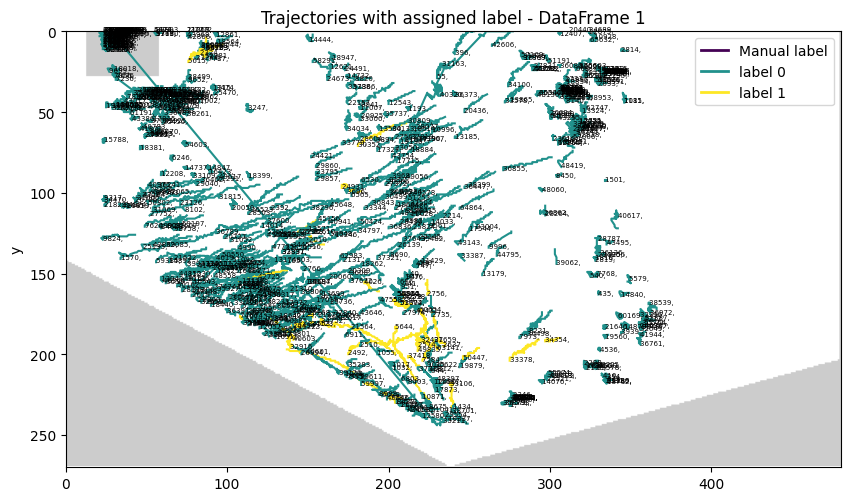

ground truth labels


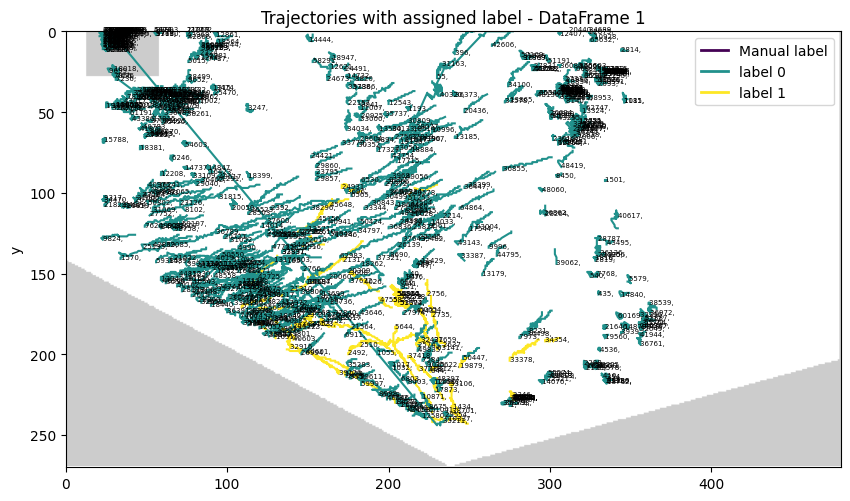

In [168]:
plotter.overwrite_classification_v2(y_pred)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="xgboost",
)

print("ground truth labels")
plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

In [48]:
dump_df = plotter.measurements_dfs[0].copy().drop(columns=['image_tile', 'binary_image'])
dump_df['classification_v2'] = dump_df['logistic_regression'].astype(int)
dump_df.to_csv('../../data/model_output/Passe3_Mar11_12-37-58_classification_v2.csv', index=False)


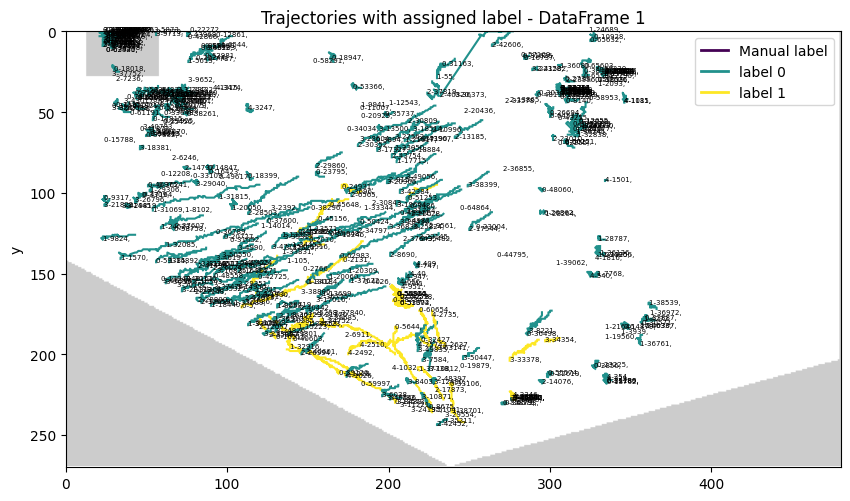

In [49]:
plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

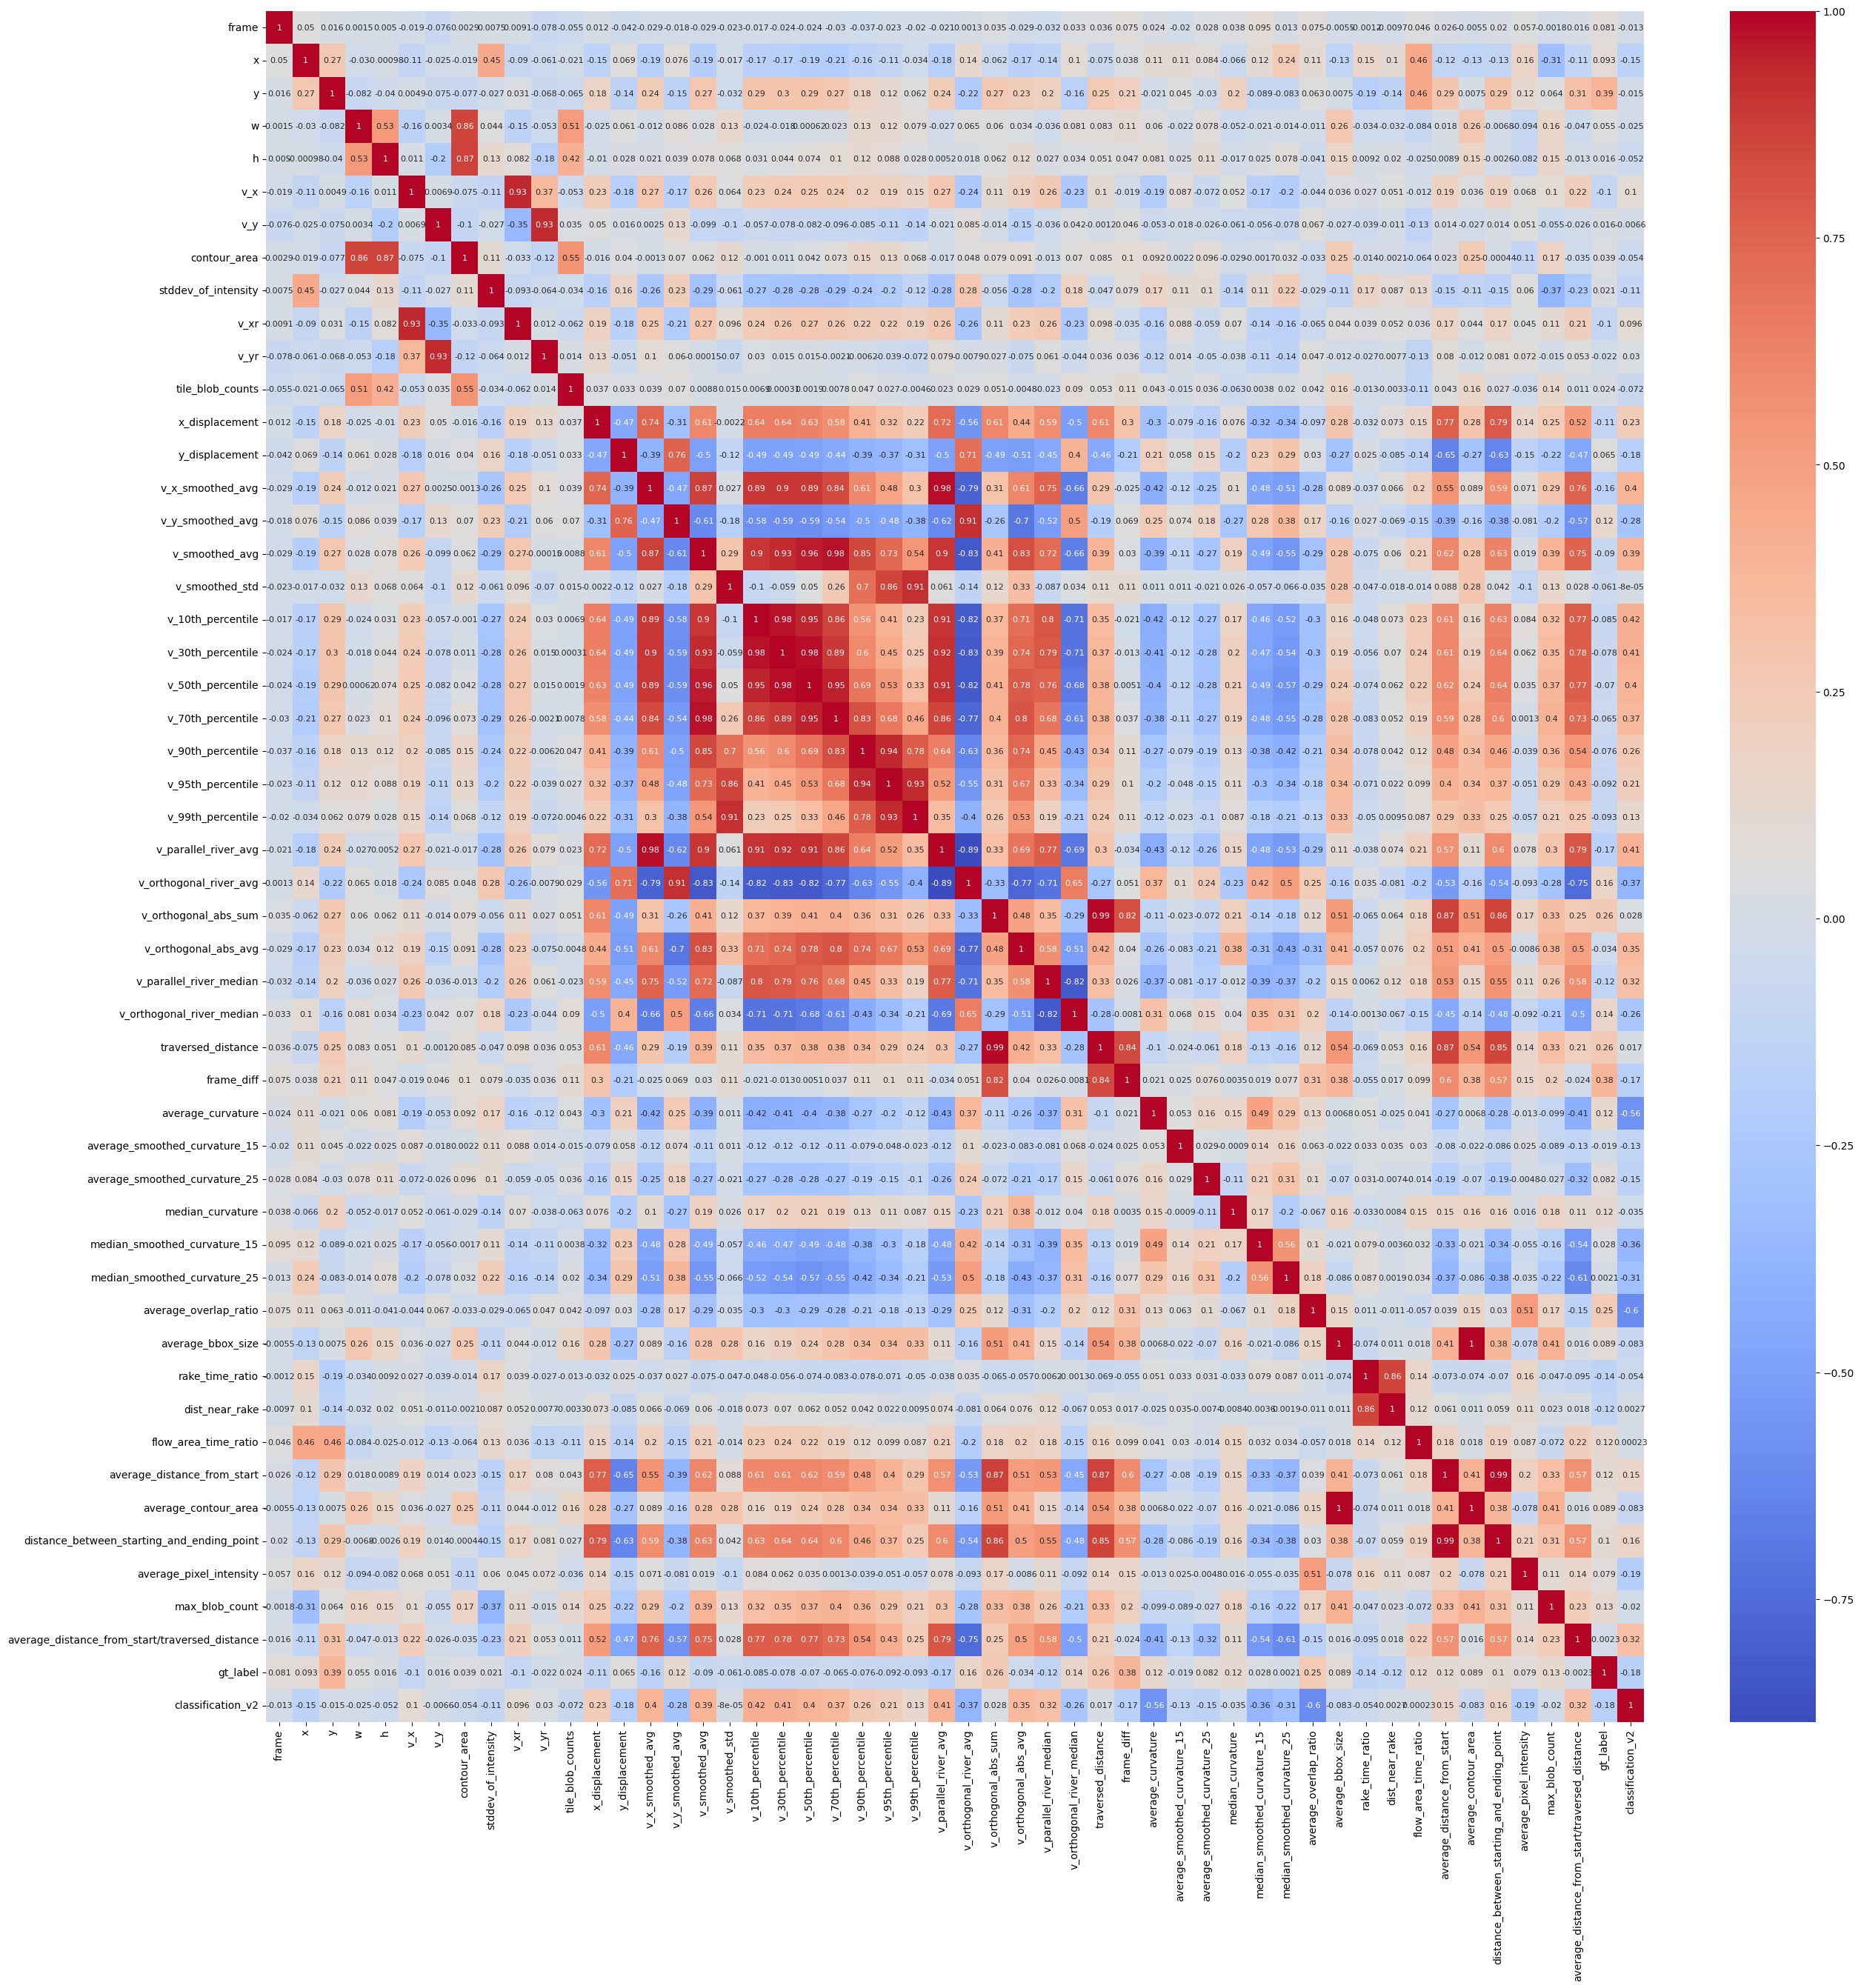

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 30))

# Compute the correlation matrix
corr_matrix = feature_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":8})

# Show the plot
plt.show()

# Shorten a Video

In [ ]:
import cv2

def cut_video(input_path, start_time, end_time):
    # Read the video
    video = cv2.VideoCapture(input_path)

    # Get the frame rate of the video
    fps = video.get(cv2.CAP_PROP_FPS)

    # Convert start and end time to seconds
    start_seconds = int(start_time.split(':')[0]) * 60 + int(start_time.split(':')[1])
    end_seconds = int(end_time.split(':')[0]) * 60 + int(end_time.split(':')[1])

    # Calculate the start and end frames
    start_frame = int(start_seconds * fps)
    end_frame = int(end_seconds * fps)

    # Set the video writer
    output_path = input_path.replace('.mp4', '_short.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (int(video.get(3)), int(video.get(4))))

    # Read and write frames within the specified time frame
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break

        if frame_count >= start_frame and frame_count <= end_frame:
            output_video.write(frame)

        frame_count += 1

        if frame_count > end_frame:
            break

    # Release the video capture and writer
    video.release()
    output_video.release()

    print(f"Video saved as {output_path}")

# Example usage
input_path = "../../data/model_output_classified/Passe3_Mar11_12-37-58_classified.mp4"
start_time = "00:45"
end_time = "01:10"

cut_video(input_path, start_time, end_time)